# Inferenza causale nella regressione multipla {#sec-causal-inference-regr}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import arviz as az
import bambi as bmb
import networkx as nx
import graphviz
from graphviz import Digraph
import warnings
warnings.filterwarnings("ignore")

In [3]:
seed: int = sum(map(ord, "regr_causal_inference"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione {.unnumbered}

Lo scopo di questo capitolo è esaminare il modello di regressione multipla come strumento per descrivere le relazioni causali. Il modello di regressione offre indubbi vantaggi: i coefficienti parziali di regressione consentono di isolare l'effetto lineare di una variabile, tenendo conto dell'influenza delle altre variabili presenti nel modello. Questo approccio permette di ottenere quello che viene comunemente chiamato "controllo statistico".

Tuttavia, è fondamentale riconoscere che questo risultato si raggiunge solo se il modello di regressione include tutte le variabili indipendenti che sono associate con la variabile dipendente e correlate con le altre variabili del modello. Nel capitolo precedente, abbiamo introdotto il concetto di errore di specificazione: se escludiamo dal modello di regressione una variabile che ha un effetto causale su $Y$ ed è correlata con gli altri predittori, le stime degli effetti causali ottenute saranno sistematicamente distorte.

Un'interpretazione ingenua dell'errore di specificazione potrebbe portare a pensare che la soluzione sia includere il maggior numero possibile di predittori, per massimizzare il controllo statistico e ridurre il rischio di errore. Tuttavia, questo approccio, che @McElreath_rethinking definisce "insalata causale", genera più problemi di quanti ne risolva.

In questo capitolo, esploreremo come la selezione delle variabili indipendenti da includere nel modello di regressione richieda una conoscenza approfondita della struttura causale del fenomeno in esame. Senza una tale comprensione, l'uso del modello di regressione può risultare più dannoso che utile. I limiti dell'approccio "insalata causale" sono chiaramente evidenziati anche dallo studio di @debertin2024synthesizing, che ha come obiettivo identificare i criteri per la selezione delle covariate da includere in un'analisi causale.

## Confondimento

Iniziamo con una definizione del fenomeno del confondimento. Il confondimento si verifica quando l'associazione tra un risultato $Y$ e un predittore di interesse $X$ differisce da quella che si osserverebbe se i valori di $X$ fossero determinati sperimentalmente.

Ad esempio, consideriamo l'associazione tra istruzione ($E$) e salario ($W$). Esistono variabili non osservate ($U$) che influenzano entrambe, come il luogo di residenza e lo status socioeconomico. Nel seguente grafo causale, ci sono due percorsi tra $E$ e $W$: 

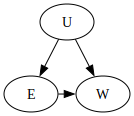

In [4]:
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("E")
    s.node("W")

f.node("U")
f.edge("U", "E")
f.edge("U", "W")
f.edge("E", "W")

f

- Percorso causale diretto: $E \rightarrow W$
- Percorso non causale indiretto: $E \leftarrow U \rightarrow W$

Solo il primo percorso ($E \rightarrow W$) rappresenta un effetto causale. Il secondo percorso ($E \leftarrow U \rightarrow W$) crea un'associazione statistica ma non causale.

Per isolare il percorso causale, la soluzione ideale è condurre un esperimento randomizzato, assegnando i livelli di istruzione $E$ casualmente, eliminando così l'influenza di $U$ su $E$. L'assegnazione casuale dell'istruzione blocca il percorso $E \leftarrow U \rightarrow W$, lasciando solo il percorso causale $E \rightarrow W$.

Tuttavia, questo esperimento non può essere eseguito. In assenza di esperimenti, è necessaria una soluzione statistica che blocchi il percorso non causale. In assenza di esperimenti, si può condizionare su $U$ aggiungendolo al modello statistico. Questo blocca il flusso di informazioni attraverso $U$, isolando l'effetto causale tra $E$ e $W$.

Ad esempio, se $U$ è la ricchezza media di una regione, conoscere $U$ (la regione) elimina l'influenza indiretta su $W$ attraverso $E$. Dopo aver appreso $U$, sapere $E$ non aggiunge ulteriori informazioni su $W$.

In sintesi, il confondimento può distorcere l'associazione tra due variabili a causa di percorsi indiretti attraverso variabili non osservate. La randomizzazione o il condizionamento su queste variabili può isolare il percorso causale, permettendo di misurare accuratamente l'effetto di una variabile sull'altra.

Questa discussione ha un'implicazione importante per il modello di regressione. Nel caso dell'esempio, solo se introduciamo nel modello di regressione la covariata $U$, ovvero se condizioniamo su $U$, possiamo stimare in maniera non distorta la relazione causale tra $E$ e $W$. Tuttavia, ci sono anche casi in cui introdurre la covariata sbagliata può introdurre distorsioni nei risultati dell'analisi di regressione. Senza una comprensione delle relazioni causali che legano le variabili, non è possibile determinare quali siano le variabili da inserire o da escludere dal modello di regressione.

## Confondimento

Iniziamo con una definizione del fenomeno del confondimento. Il confondimento si verifica quando l'associazione tra un risultato $Y$ e un predittore di interesse $X$ differisce da quella che si osserverebbe se i valori di $X$ fossero determinati sperimentalmente.

Ad esempio, consideriamo l'associazione tra istruzione ($E$) e salario ($W$). Esistono variabili non osservate ($U$) che influenzano entrambe, come il luogo di residenza e lo status socioeconomico. Nel seguente grafo causale, ci sono due percorsi tra $E$ e $W$:

```python
import graphviz
f = graphviz.Digraph()
with f.subgraph() as s:
    s.attr(rank='same')
    s.node("E")
    s.node("W")
f.node("U")
f.edge("U", "E")
f.edge("U", "W")
f.edge("E", "W")
f
```

- Percorso causale diretto: $E \rightarrow W$
- Percorso non causale indiretto: $E \leftarrow U \rightarrow W$

Solo il primo percorso ($E \rightarrow W$) rappresenta un effetto causale. Il secondo percorso ($E \leftarrow U \rightarrow W$) crea un'associazione statistica ma non causale.

Per isolare il percorso causale, la soluzione ideale è condurre un esperimento randomizzato, assegnando i livelli di istruzione $E$ casualmente, eliminando così l'influenza di $U$ su $E$. L'assegnazione casuale dell'istruzione blocca il percorso $E \leftarrow U \rightarrow W$, lasciando solo il percorso causale $E \rightarrow W$.

Tuttavia, questo esperimento non può essere eseguito. In assenza di esperimenti, è necessaria una soluzione statistica che blocchi il percorso non causale. Si può condizionare su $U$ aggiungendolo al modello statistico. Questo blocca il flusso di informazioni attraverso $U$, isolando l'effetto causale tra $E$ e $W$.

Ad esempio, se $U$ è la ricchezza media di una regione, conoscere $U$ (la regione) elimina l'influenza indiretta su $W$ attraverso $E$. Dopo aver appreso $U$, sapere $E$ non aggiunge ulteriori informazioni su $W$.

In sintesi, il confondimento può distorcere l'associazione tra due variabili a causa di percorsi indiretti attraverso variabili non osservate. La randomizzazione o il condizionamento su queste variabili può isolare il percorso causale, permettendo di misurare accuratamente l'effetto di una variabile sull'altra.

Questa discussione ha un'implicazione importante per il modello di regressione. Nel caso dell'esempio, solo se introduciamo nel modello di regressione la covariata $U$, ovvero se condizioniamo su $U$, possiamo stimare in maniera non distorta la relazione causale tra $E$ e $W$. Tuttavia, ci sono anche casi in cui introdurre la covariata sbagliata può introdurre distorsioni nei risultati dell'analisi di regressione. Senza una comprensione delle relazioni causali che legano le variabili, non è possibile determinare quali siano le variabili da inserire o da escludere dal modello di regressione.

## Bloccare i percorsi backdoor

Bloccare i percorsi di confondimento tra un predittore $X$ e un risultato $Y$ è noto come "chiudere un percorso backdoor". Non vogliamo che nessuna associazione spuria entri attraverso un percorso non causale che coinvolge il predittore $X$. Nell'esempio sopra, il percorso $E \leftarrow U \rightarrow W$ è un percorso di backdoor, poiché entra in $E$ con una freccia e collega $E$ a $W$. Questo percorso non è causale: intervenire su $E$ non provocherà un cambiamento in $W$ attraverso questo percorso, ma produrrà comunque un'associazione tra $E$ e $W$.

La buona notizia è che, dato un grafo aciclico diretto (DAG) causale, è sempre possibile determinare quali variabili controllare per chiudere tutti i percorsi di backdoor. È anche possibile identificare quali variabili non controllare per evitare di creare nuovi confondimenti. Esistono quattro tipi fondamentali di relazioni causali che combinano tutti i possibili percorsi: la biforcazione, la catena, il collider e il discendente. Pertanto, è necessario comprendere solo questi quattro concetti e come fluisce l'informazione in ciascuno di essi.

1. **Confondente**: Una variabile $U$ che causa sia il predittore $X$ sia il risultato $Y$. Aggiustare per un confondente (*fork*) è necessario per ottenere stime non distorte. 
   - Esempio: $X \leftarrow U \rightarrow Y$.

2. **Catena**: Una sequenza di variabili in cui una causa l'altra, formando un percorso diretto. Non si dovrebbe aggiustare per le variabili lungo questo percorso, poiché rappresenta il percorso causale.
   - Esempio: $X \rightarrow Z \rightarrow Y$.

3. **Collider**: Una variabile che è causata da due altre variabili. Aggiustare per un collider può introdurre confondimento, poiché si crea un'associazione spuria tra i due predittori.
   - Esempio: $X \rightarrow Z \leftarrow Y$.

4. **Discendente**: Una variabile che è causata sia dal predittore $X$ sia dal risultato $Y$. Condizionare su un discendente può introdurre un bias, distorcendo l'associazione tra $X$ e $Y$.
   - Esempio: $X \rightarrow W \leftarrow Y$ con $W$ che ha un effetto su $Z$ (discendente).

Comprendere queste relazioni e sapere come intervenire su di esse è fondamentale per costruire modelli di regressione che riflettano accuratamente le relazioni causali tra le variabili. Questo approccio permette di isolare gli effetti causali e di evitare le distorsioni introdotte da percorsi di backdoor.


## Tipi di relazioni elementari nei DAG

Ogni DAG, per quanto grande e complicato, è costruito sulle quattro relazioni elementari descritte in precedenza. Esaminiamole in dettaglio. 

### Confondimento

La configurazione detta "fork" rappresenta un classico caso di confondimento. Nel confondimento, una variabile $Z$ è una causa comune di due variabili $X$ e $Y$, generando una correlazione tra loro: $X \leftarrow Z \rightarrow Y$.  Se condiamo su $Z$, allora $X$ e $Y$ diventano indipendenti.

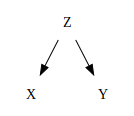

In [6]:
fork = Digraph(comment='Forchetta')
fork.node('X', 'X', shape='plaintext')
fork.node('Y', 'Y', shape='plaintext')
fork.node('Z', 'Z', shape='plaintext')
fork.edge('Z', 'X')
fork.edge('Z', 'Y')
fork

#### Esempio

Consideriamo l'effetto dell'istruzione ($X$) sul salario ($Y$) con $Z$ che rappresenta lo status socioeconomico.

#### Conseguenze del Controllo

- **Controllare $Z$**: Blocca il percorso non causale, isolando l'effetto diretto di $X$ su $Y$.
- **Non controllare $Z$**: Introduce confondimento, portando a una stima distorta dell'effetto di $X$ su $Y$.

In [7]:
n = 1000
Z = np.random.normal(0, 1, n)
X = 0.5 * Z + np.random.normal(0, 1, n)
Y = 0.8 * Z + np.random.normal(0, 1, n)

df = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

# Modello senza controllo per Z
mod1 = bmb.Model('Y ~ X', df)
results1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, X]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [8]:
az.summary(results1, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.02,0.04,-0.09,0.05,0.0,0.0,6310.32,3060.06,1.0
X,0.30,0.03,0.23,0.36,0.0,0.0,5784.06,2927.95,1.0
sigma,1.23,0.03,1.18,1.28,0.0,0.0,6424.03,3165.63,1.0


In [9]:
# Modello con controllo per Z
mod2 = bmb.Model('Y ~ X + Z', df)
results2 = mod2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, X, Z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
az.summary(results2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.03,0.03,-0.08,0.03,0.0,0.0,5749.64,3042.71,1.0
X,-0.04,0.03,-0.10,0.02,0.0,0.0,3711.94,3112.96,1.0
Z,0.84,0.04,0.77,0.90,0.0,0.0,3850.83,3388.92,1.0
sigma,0.99,0.02,0.95,1.03,0.0,0.0,5593.71,2941.94,1.0


### Catena

In una catena, una variabile $X$, influenza un mediatore $Z$, che a sua volta influenza l'esito $Y$: $X \rightarrow Z \rightarrow Y$. Condizionare su $Z$ blocca il percorso da $X$ a $Y$. 

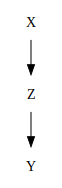

In [11]:
pipe = Digraph(comment='Tubo')
pipe.node('X', 'X', shape='plaintext')
pipe.node('Y', 'Y', shape='plaintext')
pipe.node('Z', 'Z', shape='plaintext')
pipe.edge('X', 'Z')
pipe.edge('Z', 'Y')
pipe

#### Esempio
Consideriamo l'effetto dell'apprendimento ($X$) sulla comprensione ($Y$) mediato dalla conoscenza ($Z$).

#### Conseguenze del Controllo
- **Controllare $Z$**: Blocca il percorso causale, fornendo solo l'effetto diretto di $X$ su $Y$.
- **Non controllare $Z$**: Misura l'effetto totale di $X$ su $Y$.

In [12]:
X = np.random.normal(0, 1, n)
Z = 5 * X + np.random.normal(0, 1, n)
Y = 3 * Z + np.random.normal(0, 1, n)

df = pd.DataFrame({'X': X, 'Z': Z, 'Y': Y})

# Modello senza controllo per Z
mod1 = bmb.Model('Y ~ X', df)
results1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, X]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
az.summary(results1, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.04,0.10,-0.15,0.23,0.0,0.0,6356.32,2949.31,1.0
X,14.95,0.10,14.77,15.13,0.0,0.0,6321.33,3376.27,1.0
sigma,3.20,0.07,3.06,3.33,0.0,0.0,6103.86,2993.17,1.0


In [14]:
# Modello con controllo per Z
mod2 = bmb.Model('Y ~ X + Z', df)
results2 = mod2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, X, Z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [15]:
az.summary(results2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.04,0.03,-0.03,0.10,0.0,0.0,3132.72,2315.01,1.0
X,0.23,0.16,-0.09,0.52,0.0,0.0,1234.56,1621.51,1.0
Z,2.95,0.03,2.89,3.01,0.0,0.0,1231.93,1656.26,1.0
sigma,1.03,0.02,0.99,1.07,0.0,0.0,2903.70,2513.20,1.0


### Collider

In un collider, due variabili $X$ e $Y$ influenzano una terza variabile $Z$: $X \rightarrow Z \leftarrow Y$. Condizionare su $Z$ può indurre una correlazione spuria tra $X$ e $Y$.

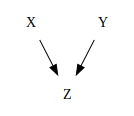

In [16]:
collider = Digraph(comment='Collider')
collider.node('X', 'X', shape='plaintext')
collider.node('Y', 'Y', shape='plaintext')
collider.node('Z', 'Z', shape='plaintext')
collider.edge('X', 'Z')
collider.edge('Y', 'Z')
collider

Il bias di selezione si verifica quando il campione che analizziamo non è rappresentativo della popolazione a causa del processo di selezione. Questo può portare a correlazioni spurie perché il processo di selezione può favorire involontariamente alcune caratteristiche.

Il bias del collider (o bias di stratificazione del collider) si verifica quando due variabili, $X$ e $Y$, influenzano una terza variabile $Z$ (il collider). Se ci condiamo su $Z$, possiamo indurre un'associazione spuria tra $X$ e $Y$, anche se queste variabili sono scorrelate nella popolazione.

Nell'esempio tratto da @McElreath_rethinking`, si suggerisce che sembra che gli studi scientifici più degni di nota siano i meno affidabili. Più è probabile che uno studio sia interessante, se vero, meno è probabile che sia vero. Più noioso è il tema, più rigorosi sono i risultati. Come può esistere questa correlazione negativa, ampiamente creduta da molti?

In realtà, tutto ciò che è necessario affinché emerga una tale correlazione negativa è che ci si preoccupin sia della rilevanza che dell'affidabilità. Che si tratti di revisione di sovvenzioni o di riviste, se editori e revisori si preoccupano di entrambi gli aspetti, allora l'atto stesso della selezione è sufficiente a rendere gli studi più rilevanti i meno affidabili. Infatti, è difficile immaginare come il processo di peer review possa evitare di creare questa correlazione negativa.

Ecco una semplice simulazione per illustrare il concetto. Supponiamo che un pannello di revisione delle sovvenzioni riceva 200 proposte di ricerca. Tra queste proposte, non vi è alcuna correlazione tra affidabilità (rigore, erudizione, plausibilità del successo) e rilevanza (valore per il benessere sociale, interesse pubblico). Il pannello pesa in ugual misura l'affidabilità e la rilevanza. Successivamente, classificano le proposte in base ai loro punteggi combinati e selezionano il 10% migliore per il finanziamento.

In [17]:
# Numero di proposte da finanziare
N = 200
# Proporzione da selezionare
p = 0.1
# Rilevanza non correlata
nw = np.random.randn(N)
# Affidabilità non correlata
tw = np.random.randn(N)
correlation = np.corrcoef(tw, nw)[0, 1]
print(correlation)

0.026051430796600182


Nello script, il processo di selezione basato sul punteggio combinato `s` induce una correlazione spuria tra `nw` e `tw`. Sebbene `nw` e `tw` siano non correlati nell'intero dataset, essi appaiono correlati nel sottoinsieme selezionato.

In [18]:
# Punteggio totale
s = nw + tw
# Soglia per il 10% migliore
q = np.quantile(s, 1 - p)
# Selezionati
selected = s >= q
# Correlazione tra affidabilità e rilevanza nei selezionati
correlation = np.corrcoef(tw[selected], nw[selected])[0, 1]
print(correlation)

-0.7082917138754293


Si noti che:

- Il punteggio combinato `s` agisce come un collider perché è influenzato sia da `nw` che da `tw`.
- Quando selezioniamo le proposte basandoci su `s` (condizioniamo su `s`), introduciamo involontariamente una correlazione tra `nw` e `tw` nel sottoinsieme selezionato.

In altre parole, condizionando su una variabile (`s`) che è influenzata sia da `nw` che da `tw`, induciamo una correlazione spuria tra queste due variabili non correlate. Questo è un esempio specifico di bias del collider, dove il processo di selezione agisce come il collider.

Per riassumere:

- **Bias di selezione**: in questo esempio si verifica perché analizziamo solo il 10% delle proposte migliori.
- **Bias del collider**: è introdotto perché la variabile di selezione `s` (punteggio totale) è influenzata sia da `nw` che da `tw`, portando a una correlazione spuria quando condiamo su `s`.

Quindi, la correlazione spuria osservata nel sottoinsieme selezionato è il risultato del bias del collider introdotto dal processo di selezione basato sul punteggio combinato.

Perché la correlazione è negativa nel sottoinsieme di dati selezionato? Perché, ad esempio, se una proposta selezionata ha una bassa affidabilità (`tw`), deve avere un'alta rilevanza (`nw`). Altrimenti, non sarebbe stata finanziata. Lo stesso vale al contrario: se una proposta ha una bassa rilevanza (`nw`), possiamo dedurre che deve avere un'affidabilità superiore alla media. Altrimenti, non sarebbe stata selezionata per il finanziamento. Questo è il concetto chiave da comprendere: quando condiamo su un collider, si creano associazioni statistiche, ma non necessariamente causali, tra le sue cause.

### Discendente

Un discendente è una variabile influenzata da un'altra variabile. Condizionare su un discendente significa parzialmente condizionare sul suo genitore. Nel DAG seguente, condizionare su $D$ condizionerà anche, in una certa misura, su $Z$. 

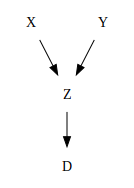

In [19]:
descendant = Digraph(comment='Discendente')
descendant.node('X', 'X', shape='plaintext')
descendant.node('Y', 'Y', shape='plaintext')
descendant.node('Z', 'Z', shape='plaintext')
descendant.node('D', 'D', shape='plaintext')
descendant.edge('X', 'Z')
descendant.edge('Y', 'Z')
descendant.edge('Z', 'D')
descendant

Questo perché $D$ contiene informazioni su $Z$, che a sua volta è un collider tra $X$ e $Y$. Condizionare su $D$ può aprire parzialmente il percorso da $X$ a $Y$ attraverso $Z$, creando un'associazione spuria tra $X$ e $Y$. Tuttavia, l'effetto di condizionare su un discendente dipende dalla relazione tra il discendente e il suo genitore. I discendenti sono comuni nei modelli causali perché spesso non possiamo misurare una variabile direttamente e dobbiamo utilizzare un proxy per essa.

#### Esempio
Consideriamo l'effetto dell'intelligenza ($X$) sul punteggio del test ($Y$) tramite il tempo di apprendimento ($Z$) e il punteggio in una simulazione ($D$).

#### Conseguenze del Controllo
- **Controllare $D$**: Può introdurre bias, creando un percorso non causale da $X$ a $Y$ attraverso $Z$.
- **Non controllare $D$**: Mantiene il percorso causale corretto da $X$ a $Y$.

In [20]:
I = np.random.normal(100, 15, n)
T = 200 - I + np.random.normal(0, 1, n)
S = 0.5 * I + 0.1 * T + np.random.normal(0, 1, n)
D = 0.7 * S + np.random.normal(0, 1, n)

df = pd.DataFrame({'I': I, 'T': T, 'S': S, 'D': D})

# Modello senza controllo per D
mod1 = bmb.Model('S ~ T', df)
results1 = mod1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, T]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [21]:
az.summary(results1, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,99.39,0.24,98.92,99.82,0.0,0.0,5831.85,3060.37,1.0
T,-0.39,0.00,-0.40,-0.39,0.0,0.0,5879.01,3269.97,1.0
sigma,1.10,0.02,1.05,1.14,0.0,0.0,6041.49,3081.54,1.0


In [22]:
# Modello con controllo per D
mod2 = bmb.Model('S ~ T + D', df)
results2 = mod2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, T, D]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [23]:
az.summary(results2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
D,0.50,0.02,0.45,0.54,0.00,0.00,2526.07,2095.97,1.0
Intercept,64.78,1.58,61.69,67.64,0.03,0.02,2486.35,2167.12,1.0
T,-0.26,0.01,-0.27,-0.24,0.00,0.00,2490.85,2271.87,1.0
sigma,0.90,0.02,0.86,0.94,0.00,0.00,3237.43,2629.65,1.0


## Come aprire o chiudere un percorso nei DAG

Per determinare quali variabili includere o escludere nel modello di regressione, è necessario seguire questa procedura:

1. **Elencare tutti i percorsi** che collegano $X$ (la potenziale causa di interesse) e $Y$ (il risultato).
2. **Classificare ciascun percorso** come aperto o chiuso. Un percorso è aperto a meno che non contenga un collider.
3. **Identificare i percorsi di backdoor**. Un percorso di backdoor ha una freccia che entra in $X$.
4. **Chiudere i percorsi di backdoor aperti**: Se ci sono percorsi di backdoor aperti, decidere su quali variabili condizionare per chiuderli, se possibile.

Condizionare su una variabile significa includerla nel modello di regressione. Per chiudere un percorso di backdoor, identifichiamo la variabile di confondimento che crea l'associazione spuria e la includiamo nel modello. Questo bloccherà il percorso, impedendo che l'associazione spuria influenzi il risultato.

## Come Costruire un DAG?

I Directed Acyclic Graphs (DAG) sono strumenti fondamentali per rappresentare relazioni causali. Tuttavia, la loro costruzione pratica presenta sfide significative, soprattutto quando la struttura causale sottostante non è completamente nota. @debertin2024synthesizing affrontano una questione cruciale: come costruire un DAG efficace quando la struttura causale del fenomeno studiato non è completamente conosciuta?

La visione tradizionale richiedeva l'identificazione e la correzione di tutte le cause comuni tra esposizione e risultato. L'approccio moderno, invece, si concentra sul bloccare i percorsi di confondimento, senza necessariamente includere tutte le variabili storicamente considerate confondenti. Idealmente, un DAG dovrebbe includere tutte le variabili che fungono da cause comuni, ma in pratica è necessario fare scelte su quali variabili includere, data la conoscenza incompleta delle relazioni causali.

Idealmente, un DAG dovrebbe includere tutte le variabili che fungono da cause comuni tra altre variabili presenti nel grafico. In pratica, però, è necessario fare delle scelte su quali variabili includere, poiché non tutte le relazioni causali tra esposizione e risultato sono completamente esplorate o conosciute.

Diversi metodi sono stati proposti per la costruzione dei DAG: 

- **Il criterio della causa disgiuntiva**, che consiglia di includere tutte le cause dirette note dell'esposizione o del risultato;
- **L'uso di covariate pretrattamento legate all'esposizione**, spesso noto come approccio "tutto incluso";
- **L'inclusione di tutti i fattori prognostici noti per il risultato**, che concentra l'attenzione sui fattori che influenzano l'outcome indipendentemente dall'esposizione.

Per valutare questi diversi approcci, @debertin2024synthesizing hanno utilizzato i dati del Coronary Drug Project (CDP). Questo studio è particolarmente utile perché si ritiene con elevata certezza che l'aderenza al placebo non abbia un effetto causale sulla mortalità, offrendo così un esempio concreto in cui l'effetto causale vero è noto essere nullo. 

### Tipologie di DAG costruiti

Nell'analisi di @debertin2024synthesizing, sono stati utilizzati tre approcci di costruzione dei DAG: 

- I DAG basati sui risultati (o outcome-driven DAG) sono grafici causali costruiti con l'obiettivo di includere principalmente variabili che sono forti fattori prognostici dell'outcome, ovvero del risultato che si intende spiegare o prevedere. In altre parole, queste variabili sono scelte perché hanno una forte associazione con l'esito finale, come la mortalità o il successo di un trattamento. L'idea alla base di questo approccio è che includendo variabili che influenzano direttamente l'outcome (come fattori di rischio ben noti), si può ottenere un modello più robusto e meno influenzato da variabili irrilevanti. In questo contesto, non si cerca di includere necessariamente tutte le variabili che potrebbero influenzare l'esposizione (ad esempio, l'aderenza al trattamento), ma piuttosto ci si concentra su quelle che possono spiegare al meglio il risultato finale. L'obiettivo di un DAG basato sui risultati è quindi quello di controllare principalmente le cause dell'outcome, in modo da correggere efficacemente il confondimento senza necessariamente includere variabili legate all'esposizione, che potrebbero non avere una forte relazione con l'outcome stesso.

- I DAG "trimmed" (o DAG ridotti) sono grafici causali che vengono semplificati rimuovendo alcune variabili dopo una revisione critica della letteratura e delle evidenze disponibili. L'obiettivo principale di questo approccio è ridurre il modello a quelle variabili che sono effettivamente rilevanti per la relazione causale che si vuole studiare, evitando di includere variabili che potrebbero non essere utili o addirittura introdurre confondimento non necessario.

- I DAG massimizzati (o maximal DAGs) sono grafici causali costruiti aggiungendo ulteriori covariate che potrebbero potenzialmente influenzare sia l'esposizione sia l'outcome. Questo approccio punta a includere il maggior numero possibile di variabili rilevanti per assicurarsi di catturare tutte le relazioni causali importanti e ridurre il rischio di bias dovuto alla mancata considerazione di fattori chiave. Si parte da un DAG di base che include le variabili principali note identificate attraverso la letteratura o da esperti del campo. Si identificano e si aggiungono ulteriori covariate che, in teoria o secondo studi precedenti, potrebbero influenzare l'esposizione (ad esempio, l'aderenza a un trattamento) o l'outcome (ad esempio, la mortalità). Queste variabili aggiuntive vengono scelte anche se la loro influenza non è ancora stata del tutto dimostrata o quantificata in maniera definitiva.

L'articolo descrive come sono stati costruiti questi diversi DAG per esplorare l'effetto dell'aderenza al placebo sulla mortalità. 

### Risultati dell'analisi

L'analisi ha rivelato quanto segue.

### 1. **DAG basati sui risultati**:

I **DAG basati sui risultati** si concentrano sull'inclusione di variabili che sono identificabili come **fattori prognostici** diretti per l'outcome (in questo caso, la mortalità). Questo approccio si basa su una selezione di covariate che, secondo le evidenze disponibili o l'esperienza degli esperti, influenzano direttamente il risultato finale. Ad esempio, potrebbero essere incluse variabili come l'età, la presenza di malattie cardiovascolari preesistenti o altre condizioni mediche rilevanti.

- **Vantaggi**: Questo approccio ha prodotto stime che erano **coerenti** con quelle ottenute nelle precedenti analisi del CDP. Anche se l'inclusione di covariate di base ha ridotto il confondimento, non è stata sufficiente per eliminarlo completamente. Tuttavia, con l'inclusione di **covariate che variano nel tempo** (ad esempio, l'aderenza che cambia tra le visite di follow-up), il DAG basato sui risultati è riuscito ad avvicinarsi molto al valore nullo atteso. Questo indica che il controllo del confondimento è migliorato quando sono state aggiunte variabili che tengono conto delle dinamiche temporali.

- **Svantaggi**: L'approccio non è perfetto perché, anche includendo i principali fattori prognostici, il confondimento non viene eliminato del tutto quando si considerano solo variabili di base. Alcune relazioni temporali e dinamiche tra variabili possono essere ignorate se non si considerano covariate variabili nel tempo.

### 2. **DAG trimmed**:

I **DAG trimmed** sono una versione semplificata del DAG basato sui risultati. In questo approccio, gli autori hanno rimosso le variabili che, sulla base della letteratura o delle evidenze empiriche, non sembrano avere una forte influenza sull'esposizione o sull'outcome. L'obiettivo è rendere il modello più snello, includendo solo le variabili realmente rilevanti e riducendo il rischio di introdurre **sovra-aggiustamento** o varianza inutile.

- **Vantaggi**: I DAG trimmed hanno prodotto stime più **precise** rispetto ai DAG basati sui risultati. Questo è dovuto al fatto che la rimozione di variabili irrilevanti ha ridotto la **varianza** delle stime, rendendo i risultati più stabili e robusti. Nonostante la rimozione di alcune covariate, il DAG trimmed ha mantenuto un buon controllo del confondimento, senza sacrificare la validità delle stime. Inoltre, la semplificazione ha migliorato l'efficienza del modello, permettendo di focalizzarsi su variabili che hanno un reale impatto sul risultato.

- **Svantaggi**: Anche se questo approccio riduce la varianza, c'è il rischio che alcune variabili, che potrebbero avere un'influenza marginale ma significativa, vengano eliminate. Tuttavia, nel caso analizzato, questo non ha avuto effetti negativi significativi, e il DAG trimmed ha dimostrato di funzionare bene.

### 3. **DAG massimizzati**:

I **DAG massimizzati** rappresentano un approccio opposto a quello dei DAG trimmed. In questo caso, gli autori hanno scelto di **aggiungere ulteriori covariate** che potrebbero influenzare sia l'esposizione che l'outcome. L'obiettivo è assicurarsi di non escludere nessuna variabile potenzialmente rilevante, inclusi fattori legati allo stile di vita, condizioni mediche aggiuntive, fattori psicologici, e altre caratteristiche non incluse nei DAG di base o trimmed.

- **Vantaggi**: L'idea di base dietro i DAG massimizzati è che includendo più variabili, si riduca il rischio di **bias dovuto a variabili non osservate**. Si spera che, catturando un numero più ampio di fattori potenzialmente influenti, si ottenga un modello più completo, che tenga conto di tutte le possibili relazioni causali tra esposizione e outcome.

- **Svantaggi**: Tuttavia, l'analisi ha mostrato che i **DAG massimizzati hanno avuto prestazioni peggiori** rispetto agli altri approcci nel controllo del confondimento. Aggiungere molte covariate non ha migliorato il controllo del bias e ha invece prodotto **stime meno accurate** e distanti dal valore nullo. Questo fenomeno può essere attribuito a un fenomeno noto come **sovra-aggiustamento**: includere variabili che non sono fortemente associate con l'outcome o che non sono necessarie per il controllo del confondimento può **amplificare il bias**. Alcune delle variabili aggiunte, come fattori legati allo stile di vita o alla salute mentale, potrebbero aver introdotto rumore nei dati, aumentando l'incertezza nelle stime.

- **Conclusione sui DAG massimizzati**: Anche se l'intenzione era di creare un modello più completo e dettagliato, questo approccio ha introdotto complessità e ha peggiorato la qualità delle stime. Questo conferma la necessità di essere selettivi nell'inclusione delle covariate, evitando l'aggiunta di variabili che non contribuiscono effettivamente al controllo del confondimento.

### Differenze tra i tre approcci:

- **DAG basati sui risultati**: Si concentrano sull'inclusione di variabili chiave che influenzano direttamente l'outcome. Sono un buon punto di partenza ma non eliminano del tutto il confondimento.
- **DAG trimmed**: Riducono la varianza e migliorano la precisione delle stime eliminando variabili non necessarie, senza introdurre bias significativo.
- **DAG massimizzati**: Introducono più covariate per coprire ogni potenziale fattore, ma questo può portare a sovra-aggiustamento, peggiorando il controllo del confondimento e aumentando il bias.

### Conclusioni:

L'analisi di Debertin et al. suggerisce che un approccio equilibrato come quello del *DAG trimmed* offre il miglior compromesso tra controllo del confondimento e precisione delle stime. Includere solo le variabili strettamente necessarie (come nei DAG basati sui risultati) può essere efficace, ma semplificare ulteriormente il modello eliminando variabili irrilevanti (DAG trimmed) può migliorare ulteriormente la qualità delle stime. Al contrario, l'aggiunta di troppe variabili, come nei *DAG massimizzati*, può peggiorare i risultati e amplificare il bias, specialmente quando si includono covariate non strettamente collegate all'outcome.

Questo caso studio conferma che la selezione delle variabili per il controllo del confondimento tramite i DAG ha un impatto rilevante sui risultati. I risultati supportano teorie secondo cui è importante evitare di includere variabili debolmente associate all'outcome e concentrarsi invece sull'identificazione di fattori prognostici per il risultato.

## Riflessioni conclusive

In conclusione, le osservazioni precedenti dimostrano che l'inferenza causale non può essere affrontata semplicemente applicando meccanicamente il modello statistico della regressione lineare. Senza ulteriori conoscenze, che non possono essere derivate esclusivamente dai dati osservati, non è possibile ottenere stime non distorte degli effetti causali. L'inferenza causale va oltre le tecniche statistiche: essa richiede informazioni supplementari sulle caratteristiche del fenomeno studiato.

Per trarre conclusioni corrette sui meccanismi causali, è essenziale disporre di informazioni dettagliate sul processo generativo dei dati. Benché spesso queste informazioni non siano direttamente disponibili, i ricercatori possono adottare strategie per minimizzare il rischio di errori interpretativi. Un passo fondamentale consiste nell'identificare ipotetici meccanismi causali prima di procedere con le stime degli effetti, utilizzando diagrammi causali come i grafici aciclici diretti per mappare le relazioni tra le variabili. Questo processo aiuta a determinare quali fattori includere nell'analisi, seguendo il "backdoor criterion" proposto da Judea Pearl, per chiudere i percorsi indiretti tra esposizione ed esito che potrebbero introdurre confondimenti.

In assenza di una comprensione del fenomeno in esame, è cruciale che i ricercatori prestino attenzione all'ordine temporale dei fattori. Questo approccio, fondamentale per l'inferenza causale, implica che l'esposizione avvenga prima dell'esito per stabilire una relazione causale plausibile. Inoltre, è importante che tutte le covariate considerate nell'analisi precedano temporalmente l'esposizione per evitare potenziali bias di specificazione, specialmente nei contesti di collider e mediazione. Seguendo questi principi, i ricercatori possono ridurre il rischio di stime errate degli effetti causali.

| Termine Tecnico | Spiegazione |
| --------------- | ----------- |
| (1) Collider | La variabile $X$, causa $Z$, e l'esito, $Y$, causa $Z$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $X \sim \mathcal{N}(0,1)$, $Y = X + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$; $Z = 0.45X + 0.77Y + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$ |
| (2) Confounder | La variabile $Z$ causa sia la variabile indipendente $X$, sia l'esito, $Y$. Non aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene un risultato distorto. Meccanismo di generazione dei dati: $Z \sim \mathcal{N}(0,1)$, $X = Z + \varepsilon_x$, $\varepsilon_x \sim \mathcal{N}(0,1)$; $Y = 0.5X + Z + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$ |
| (3) Mediator | La variabile $X$ causa $Z$ che a sua volta causa l'esito $Y$. Aggiustando per $Z$ quando si stima l'effetto di $X$ su $Y$ si ottiene l'effetto diretto, non aggiustando per $Z$ si ottiene l'effetto totale di $X$ su $Y$. L'effetto diretto rappresenta la relazione tra $X$ e $Y$ indipendentemente da qualsiasi mediatore, mentre l'effetto totale include sia l'effetto diretto sia qualsiasi effetto indiretto mediato dal mediatore potenziale. Meccanismo di generazione dei dati: $X \sim \mathcal{N}(0,1)$, $Z = X + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$; $Y = Z + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$ |
| (4) Discendente | La variabile $X$ e l’esito $Y$ hanno una variabile discendente comune $Z$. Non aggiustando per $Z$ quando si stima l’effetto di $X$ su $Y$ si ottiene una stima non distorta. Tuttavia, aggiustando per $Z$, si introduce un bias. Meccanismo di generazione dei dati: $X \sim \mathcal{N}(0,1)$, $Y = X + \varepsilon_y$, $\varepsilon_y \sim \mathcal{N}(0,1)$; $Z = 0.5X + 0.5Y + \varepsilon_z$, $\varepsilon_z \sim \mathcal{N}(0,1)$ |

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sat Jul 27 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

networkx   : 3.3
pandas     : 2.2.2
bambi      : 0.14.0
seaborn    : 0.13.2
graphviz   : 0.20.3
numpy      : 1.26.4
arviz      : 0.18.0
matplotlib : 3.9.1
statsmodels: 0.14.2

Watermark: 2.4.3

